# Forecasting Walmart's products prices

## Bartłomiej Adamiec

**Why this data?**

The dataset stands out from others, including holidays for, United States and payment days for SNAP programme benefit days (exogenous variables). The full dataset requires forecasting for 30 490 simultaneous time series organized hierarchically: States → Stores → Categories → Departments → Products.

**Goal:**

The object of this analysis is to optimize food inventory management to prevent stockouts and minimize overstocking. This is particularly critical for fresh food categories due to their limited shelf life.

**Kaggle:**

A popular platform for data analysts and machine learning engineers. It organizes competitions for data community, collect datasets etc. People can share their work e.g. Jupyter Notebooks.

**Dataset description:**

Competition data (M5 Forecasting - Accuracy) from Kaggle. Task in competition was to predict sales in Walmart chain-store for next 28 days period. Dataset
consists of 5 `.csv` files reminding relational database in star scheme. The historical sales (`sales_train_validation.csv`) is fact table, time (`calendar.csv`) and prices (`sales_prices.csv`) are dimensions tables.

**Short files description**

* `sell_prices.csv` - contains the unit price of products in USD per store and week.
* `calendar.csv` - provides information about dates (various formats), SNAP entitlement days, and holidays.
* `sales_train_validation.csv` -  historical daily unit sales data per product and store in wide format (covering days d_1 to d_1913).
* `sales_train_evaluation.csv` - identical to validation but includes next 28 days. Released after the competition.
* `sample_submission.csv` - the required submission format for competition participants.

[Source](https://www.kaggle.com/competitions/m5-forecasting-accuracy/datam)

## Conclusions
An increase in overall food sales at Walmart. This isn't a large trend, but it is noticeable and confirmed by the Kendall's Tau test.
Possible explanations:
* Population growth in California/USA
* Attractive prices at the massive discount store
* Walmart's monopolization of the market

Slight increase in loose and processed foods. I think it's worth to deep into it.

The days with the **lowest** sales volume are consistently **Christmas** (25.12.XXXX), when sales drop to zero due to store closures.

**Strong weekly seasonality:**
* Peak of sales volume - Saturdays
* Lowest sales volume - Tuesdays and Wednesdays

Foods combined are non-stationary in both tests. Ambiguous non-stationarity for time series grouped by departments, both KPPS (non-stationary around trend) and ADF (stationary) are significant. This suggests that time series are difference stationary. In ARIMA I would need to difference before training model, but in Holt - Winters I don't have to.

Residuals from STL decomposition do not follow a normal distribution. Very high kurtosis due to high fluctuations in extreme values.

The **"Fresh Food"** department (produce, raw meat) accounts for t**he highest sales volume.**

Despite of my earlier assumptions simpler model show better predictions. Prophet predicted with bigger error (MAPE = 10.67%) than Holt - Winters exponential smoothing for additional trend and seasonality (MAPE = **7.09%**). Which positions my predictions in **top of the competition's results.**

### Importing data

In [1]:
import pandas as pd
from pathlib import Path

In [2]:
data_directory = Path("m5-forecasting-accuracy")

data = {}

for file_path in data_directory.glob("*.csv"):
    file_name = file_path.stem

    print(f"Loading file: {file_name}")

    data[file_name] = pd.read_csv(file_path)

Loading file: sell_prices
Loading file: sample_submission
Loading file: calendar
Loading file: sales_train_validation
Loading file: sales_train_evaluation


##### Sell prices

In [3]:
sell_prices = data['sell_prices']
sell_prices.head()
# sell_price is net price

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [4]:
print("Rows:", sell_prices.shape[0])
print("Stores:", sell_prices['store_id'].unique())
print("Sum of distinct items:", sell_prices['item_id'].nunique())
print(sell_prices.isna().any())

Rows: 6841121
Stores: ['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
Sum of distinct items: 3049
store_id      False
item_id       False
wm_yr_wk      False
sell_price    False
dtype: bool


##### Calendar

In [5]:
# wday = 1 is saturday!!!
calendar = data['calendar']
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [6]:
print("Rows:", calendar.shape[0])
print("Columns:", calendar.columns,"\n")
print("Event types:", calendar['event_type_1'].unique())
# SNAP - Supplemental Nutrition Assistance Program, if in row for snap_ column value is 1 that means in this day people in exact state have received money for food
# CA - California
# TX - Texas
# WI - Wisconsin
print(calendar.isna().any())
# num_cols = ["wm_yr_wk", "wday", "month", "year"]

Rows: 1969
Columns: Index(['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI'],
      dtype='object') 

Event types: [nan 'Sporting' 'Cultural' 'National' 'Religious']
date            False
wm_yr_wk        False
weekday         False
wday            False
month           False
year            False
d               False
event_name_1     True
event_type_1     True
event_name_2     True
event_type_2     True
snap_CA         False
snap_TX         False
snap_WI         False
dtype: bool


##### Validation

In [7]:
validation = data['sales_train_validation']
validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [8]:
# d_ is id for distinct day, value in column is quantity of product sold in this day
print("Rows:", validation.shape[0])
print(validation.isna().any())

Rows: 30490
id          False
item_id     False
dept_id     False
cat_id      False
store_id    False
            ...  
d_1909      False
d_1910      False
d_1911      False
d_1912      False
d_1913      False
Length: 1919, dtype: bool


##### Evaluation

In [9]:
evaluation = (data['sales_train_evaluation'])
evaluation.head()
# the same thing that is in validation but have 28 more days

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


#### Optimizing

In [10]:
def to_int_16(dataframe):
    for col in dataframe.columns:
        if "int" in str(dataframe[col].dtype):
            dataframe[col] = dataframe[col].astype("int16")

In [11]:
to_int_16(calendar)
to_int_16(validation)
to_int_16(sell_prices)

In [12]:
ca1_sell_prices = sell_prices[sell_prices["store_id"] == "CA_1"]
ca1_validation = validation[validation["store_id"] == "CA_1"]

In [13]:
ca1_validation_columns_d = []
for col in ca1_validation.columns:
    if col.startswith("d_"):
        ca1_validation_columns_d.append(col)

ca1_validation_long = pd.melt(ca1_validation, value_vars=ca1_validation_columns_d, id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"], var_name="d_id", value_name="quantity_sold")

In [14]:
ca1_validation_calendar = pd.merge(ca1_validation_long, calendar, how="inner", left_on="d_id", right_on="d")
ca1_validation_calendar.drop(columns=["d_id"], inplace=True)
ca1_validation_calendar.head()

,id,item_id,dept_id,cat_id,store_id,state_id,quantity_sold,date,wm_yr_wk,weekday,...,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,Saturday,...,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,Saturday,...,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,Saturday,...,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,Saturday,...,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29,11101,Saturday,...,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0


In [15]:
columns_to_drop = ["id", "store_id", "state_id", "weekday", "wday", "month", "year", "d", "snap_WI", "snap_TX"]
ca1_validation_calendar.drop(columns=columns_to_drop, inplace=True)
ca1_validation_calendar.head()

,item_id,dept_id,cat_id,quantity_sold,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0


In [16]:
ca1_validation_calendar_sell_prices = pd.merge(ca1_validation_calendar, ca1_sell_prices, how="left", on=["wm_yr_wk", "item_id"])
ca1_validation_calendar_sell_prices.head()

,item_id,dept_id,cat_id,quantity_sold,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,store_id,sell_price
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,NaN,NaN
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,NaN,NaN
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,NaN,NaN
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,NaN,NaN
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,NaN,NaN


In [17]:
ca1_validation_calendar_sell_prices["sell_price"].info() # Can't convert to int16 because of NaN
ca1_validation_calendar_sell_prices["date"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 5832737 entries, 0 to 5832736
Series name: sell_price
Non-Null Count    Dtype  
--------------    -----  
4702895 non-null  float64
dtypes: float64(1)
memory usage: 44.5 MB
<class 'pandas.core.series.Series'>
RangeIndex: 5832737 entries, 0 to 5832736
Series name: date
Non-Null Count    Dtype 
--------------    ----- 
5832737 non-null  object
dtypes: object(1)
memory usage: 44.5+ MB


In [18]:
print(round(ca1_validation_calendar_sell_prices.memory_usage().sum()/1024**2, 2), "MB")

478.38 MB


In [19]:
ca1_validation_calendar_sell_prices["date"] = pd.to_datetime(ca1_validation_calendar_sell_prices["date"])
ca1_validation_calendar_sell_prices.rename(columns={"date": "ds", "quantity_sold": "y"}, inplace=True)

In [20]:
foods = ca1_validation_calendar_sell_prices[ca1_validation_calendar_sell_prices["cat_id"] == "FOODS"]

foods = foods.groupby("ds").agg({
    "y": "sum",
    "event_name_1": "first",
    "event_name_2": "first",
    "event_type_1": "first",
    "event_type_2": "first",
    "snap_CA": "first"
}).reset_index()

foods["event_name_1"] = foods["event_name_1"].fillna("None")
foods["event_name_2"] = foods["event_name_2"].fillna("None")
foods["event_type_1"] = foods["event_type_1"].fillna("None")
foods["event_type_2"] = foods["event_type_2"].fillna("None")

print("Usage:", round(foods.memory_usage().sum()/1024**2, 2), "MB")
foods.head()

Usage: 0.08 MB


,ds,y,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,2011-01-29,3239,None,None,None,None,0
1,2011-01-30,3137,None,None,None,None,0
2,2011-01-31,2008,None,None,None,None,0
3,2011-02-01,2258,None,None,None,None,1
4,2011-02-02,2032,None,None,None,None,1


In [21]:
loose_processed = ca1_validation_calendar_sell_prices[ca1_validation_calendar_sell_prices["dept_id"] == "FOODS_1"]

loose_processed = loose_processed.groupby("ds").agg({
    "y": "sum",
    "event_name_1": "first",
    "event_name_2": "first",
    "event_type_1": "first",
    "event_type_2": "first",
    "snap_CA": "first"
}).reset_index()

loose_processed["event_name_1"] = loose_processed["event_name_1"].fillna("None")
loose_processed["event_name_2"] = loose_processed["event_name_2"].fillna("None")
loose_processed["event_type_1"] = loose_processed["event_type_1"].fillna("None")
loose_processed["event_type_2"] = loose_processed["event_type_2"].fillna("None")
loose_processed.head()

,ds,y,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,2011-01-29,297,None,None,None,None,0
1,2011-01-30,284,None,None,None,None,0
2,2011-01-31,214,None,None,None,None,0
3,2011-02-01,175,None,None,None,None,1
4,2011-02-02,182,None,None,None,None,1


In [22]:
dairy_refrigerated = ca1_validation_calendar_sell_prices[ca1_validation_calendar_sell_prices["dept_id"] == "FOODS_2"]

dairy_refrigerated = dairy_refrigerated.groupby("ds").agg({
    "y": "sum",
    "event_name_1": "first",
    "event_name_2": "first",
    "event_type_1": "first",
    "event_type_2": "first",
    "snap_CA": "first"
}).reset_index()

dairy_refrigerated["event_name_1"] = dairy_refrigerated["event_name_1"].fillna("None")
dairy_refrigerated["event_name_2"] = dairy_refrigerated["event_name_2"].fillna("None")
dairy_refrigerated["event_type_1"] = dairy_refrigerated["event_type_1"].fillna("None")
dairy_refrigerated["event_type_2"] = dairy_refrigerated["event_type_2"].fillna("None")
dairy_refrigerated.head()

,ds,y,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,2011-01-29,674,None,None,None,None,0
1,2011-01-30,655,None,None,None,None,0
2,2011-01-31,396,None,None,None,None,0
3,2011-02-01,476,None,None,None,None,1
4,2011-02-02,354,None,None,None,None,1


In [23]:
fresh = ca1_validation_calendar_sell_prices[ca1_validation_calendar_sell_prices["dept_id"] == "FOODS_3"]

fresh = fresh.groupby("ds").agg({
    "y": "sum",
    "event_name_1": "first",
    "event_name_2": "first",
    "event_type_1": "first",
    "event_type_2": "first",
    "snap_CA": "first"
}).reset_index()

fresh["event_name_1"] = fresh["event_name_1"].fillna("None")
fresh["event_name_2"] = fresh["event_name_2"].fillna("None")
fresh["event_type_1"] = fresh["event_type_1"].fillna("None")
fresh["event_type_2"] = fresh["event_type_2"].fillna("None")
fresh.head()

,ds,y,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,2011-01-29,2268,None,None,None,None,0
1,2011-01-30,2198,None,None,None,None,0
2,2011-01-31,1398,None,None,None,None,0
3,2011-02-01,1607,None,None,None,None,1
4,2011-02-02,1496,None,None,None,None,1


## EDA

### Moving Average

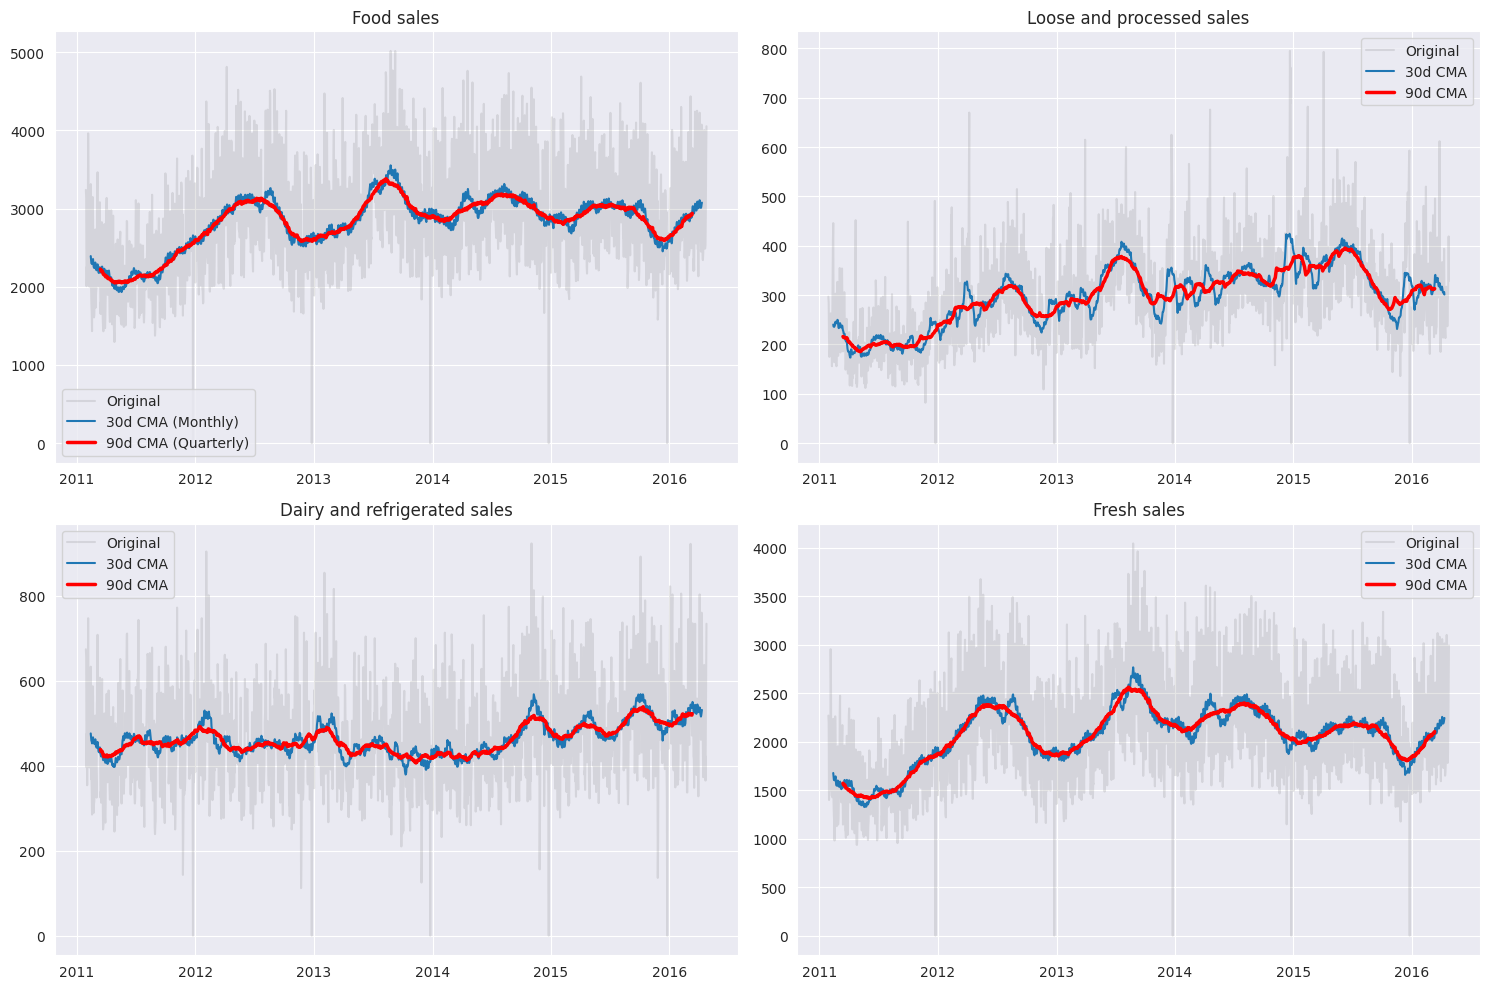

In [24]:
import matplotlib.pyplot as plt

# Centred Moving Average
foods_ma30 = foods['y'].rolling(window=30, center=True).mean()
loose_processed_ma30 = loose_processed['y'].rolling(window=30, center=True).mean()
dairy_refrigerated_ma30 = dairy_refrigerated['y'].rolling(window=30, center=True).mean()
fresh_ma30 = fresh['y'].rolling(window=30, center=True).mean()

foods_ma90 = foods['y'].rolling(window=90, center=True).mean()
loose_processed_ma90 = loose_processed['y'].rolling(window=90, center=True).mean()
dairy_refrigerated_ma90 = dairy_refrigerated['y'].rolling(window=90, center=True).mean()
fresh_ma90 = fresh['y'].rolling(window=90, center=True).mean()

# Plot
fig, ((foods_plot, loose_processed_plot), (dairy_refrigerated_plot, fresh_plot)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

foods_plot.set_title('Food sales')
foods_plot.plot(foods['ds'], foods['y'], alpha=0.2, label='Original', color='gray')
foods_plot.plot(foods['ds'], foods_ma30, label='30d CMA (Monthly)', linewidth=1.5)
foods_plot.plot(foods['ds'], foods_ma90, label='90d CMA (Quarterly)', linewidth=2.5, color='red')
foods_plot.legend()

loose_processed_plot.set_title('Loose and processed sales')
loose_processed_plot.plot(loose_processed['ds'], loose_processed['y'], alpha=0.2, label='Original', color='gray')
loose_processed_plot.plot(loose_processed['ds'], loose_processed_ma30, label='30d CMA', linewidth=1.5)
loose_processed_plot.plot(loose_processed['ds'], loose_processed_ma90, label='90d CMA', linewidth=2.5, color='red')
loose_processed_plot.legend()

dairy_refrigerated_plot.set_title('Dairy and refrigerated sales')
dairy_refrigerated_plot.plot(dairy_refrigerated['ds'], dairy_refrigerated['y'], alpha=0.2, label='Original', color='gray')
dairy_refrigerated_plot.plot(dairy_refrigerated['ds'], dairy_refrigerated_ma30, label='30d CMA', linewidth=1.5)
dairy_refrigerated_plot.plot(dairy_refrigerated['ds'], dairy_refrigerated_ma90, label='90d CMA', linewidth=2.5, color='red')
dairy_refrigerated_plot.legend()

fresh_plot.set_title('Fresh sales')
fresh_plot.plot(fresh['ds'], fresh['y'], alpha=0.2, label='Original', color='gray')
fresh_plot.plot(fresh['ds'], fresh_ma30, label='30d CMA', linewidth=1.5)
fresh_plot.plot(fresh['ds'], fresh_ma90, label='90d CMA', linewidth=2.5, color='red')
fresh_plot.legend()

plt.tight_layout()
plt.show()

### Trend check

#### Hodrick - Prescott Filter

/home/bartomiej/Pulpit/analiza_danych/analiza_danych/lib/python3.12/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


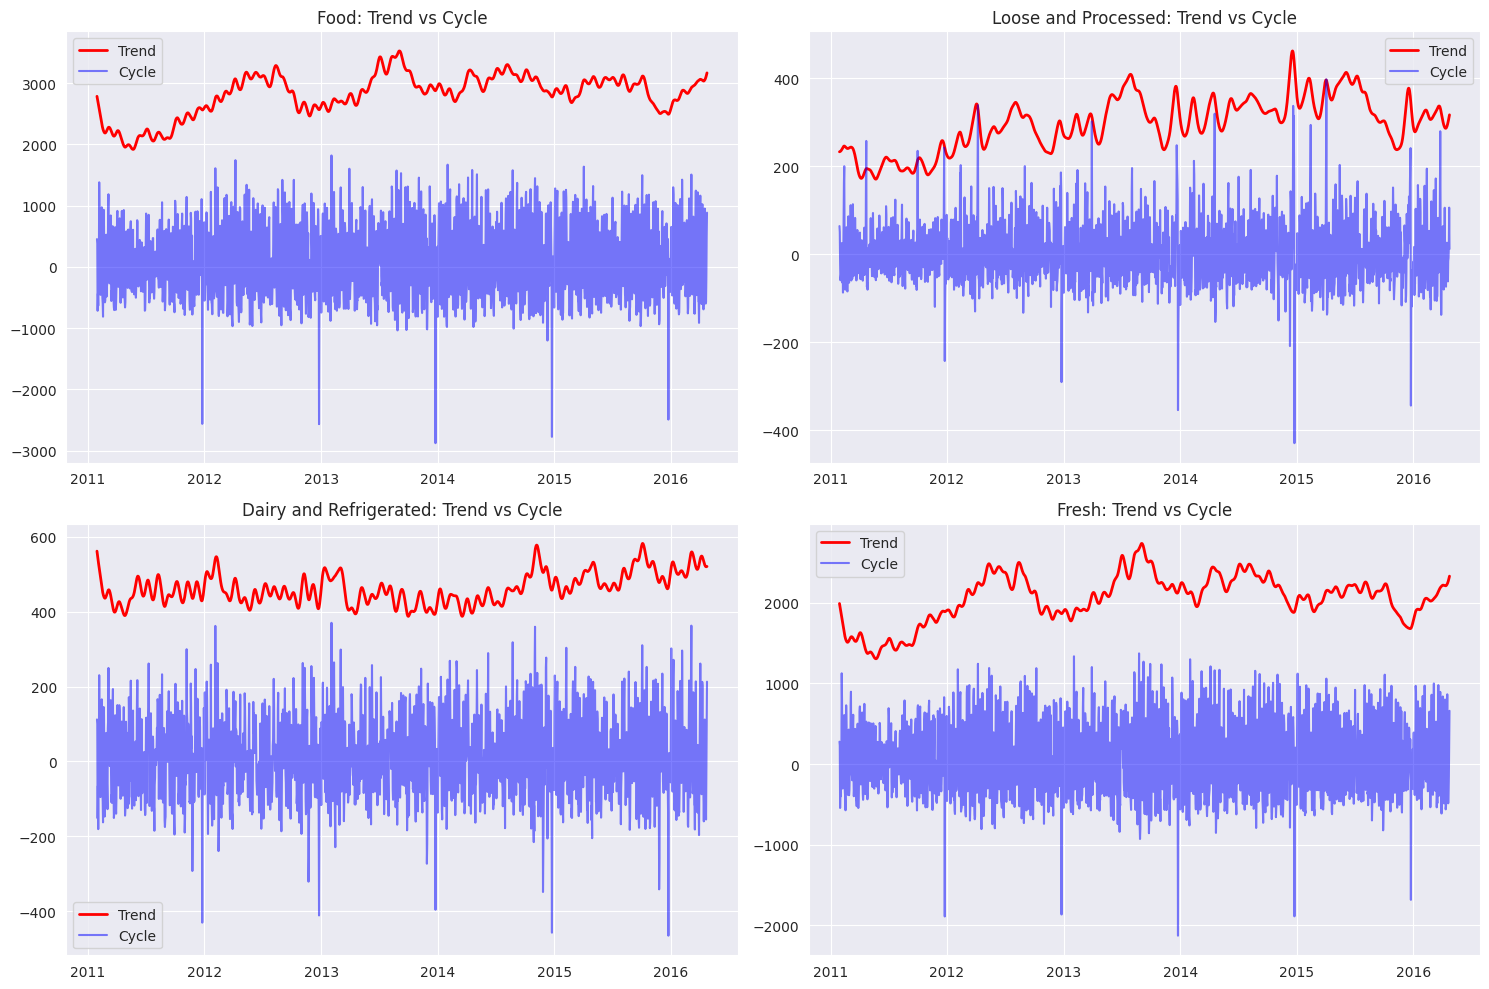

In [25]:
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter

# HP Filter for quarter data
foods_cycle, foods_trend = hpfilter(foods["y"], lamb=1600)
dairy_refrigerated_cycle, dairy_refrigerated_trend = hpfilter(dairy_refrigerated["y"], lamb=1600)
loose_processed_cycle, loose_processed_trend = hpfilter(loose_processed["y"], lamb=1600)
fresh_cycle, fresh_trend = hpfilter(fresh["y"], lamb=1600)

# Plot
fig, ((foods_plot, loose_processed_plot), (dairy_refrigerated_plot, fresh_plot)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Foods
foods_plot.set_title('Food: Trend vs Cycle')
foods_plot.plot(foods["ds"], foods_trend, color='red', label='Trend', linewidth=2)
foods_plot.plot(foods["ds"], foods_cycle, color='blue', alpha=0.5, label='Cycle')
foods_plot.legend()

# Loose and Processed
loose_processed_plot.set_title('Loose and Processed: Trend vs Cycle')
loose_processed_plot.plot(loose_processed["ds"], loose_processed_trend, color='red', label='Trend', linewidth=2)
loose_processed_plot.plot(loose_processed["ds"], loose_processed_cycle, color='blue', alpha=0.5, label='Cycle')
loose_processed_plot.legend()

# Dairy and Refrigerated
dairy_refrigerated_plot.set_title('Dairy and Refrigerated: Trend vs Cycle')
dairy_refrigerated_plot.plot(dairy_refrigerated["ds"], dairy_refrigerated_trend, color='red', label='Trend', linewidth=2)
dairy_refrigerated_plot.plot(dairy_refrigerated["ds"], dairy_refrigerated_cycle, color='blue', alpha=0.5, label='Cycle')
dairy_refrigerated_plot.legend()

# Fresh
fresh_plot.set_title('Fresh: Trend vs Cycle')
fresh_plot.plot(fresh["ds"], fresh_trend, color='red', label='Trend', linewidth=2)
fresh_plot.plot(fresh["ds"], fresh_cycle, color='blue', alpha=0.5, label='Cycle')
fresh_plot.legend()

plt.tight_layout()
plt.show()

In [26]:
min_idx = loose_processed['y'].idxmin()
worst_day = loose_processed.loc[min_idx]
print(f"Date: {worst_day['ds']}")
print(f"Event 1: {worst_day['event_name_1']}")

Date: 2011-12-25 00:00:00
Event 1: Christmas


We can see that every year, on one day, sales are much lower exactly on Christmas 25/12/20xx.

#### Kendall Tau

In [27]:
from scipy.stats import kendalltau

# Computing tau for each dataframe
foods_tau = kendalltau(foods["ds"], foods["y"])
loose_processed_tau = kendalltau(loose_processed["ds"], loose_processed["y"])
dairy_refrigerated_tau = kendalltau(dairy_refrigerated["ds"], dairy_refrigerated["y"])
fresh_tau = kendalltau(fresh["ds"], fresh["y"])

print(f"Foods \np-value: {foods_tau.pvalue:.2f}\ntau: {foods_tau.statistic:.2f}")
print("="*50)
print(f"Loose and Processed \np-value: {loose_processed_tau.pvalue:.2f}\ntau: {loose_processed_tau.statistic:.2f}")
print("="*50)
print(f"Dairy and Refrigerated \np-value: {dairy_refrigerated_tau.pvalue:.2f}\ntau: {dairy_refrigerated_tau.statistic:.2f}")
print("="*50)
print(f"Fresh \np-value: {fresh_tau.pvalue:.2f}\ntau: {fresh_tau.statistic:.2f}")

Foods 
p-value: 0.00
tau: 0.18
Loose and Processed 
p-value: 0.00
tau: 0.32
Dairy and Refrigerated 
p-value: 0.00
tau: 0.09
Fresh 
p-value: 0.00
tau: 0.16


Each test is statistically significant. The "Foods" category shows the strongest monotonicity, although the trend is still moderate. The remaining categories show a weak trend.

### Seasonality check

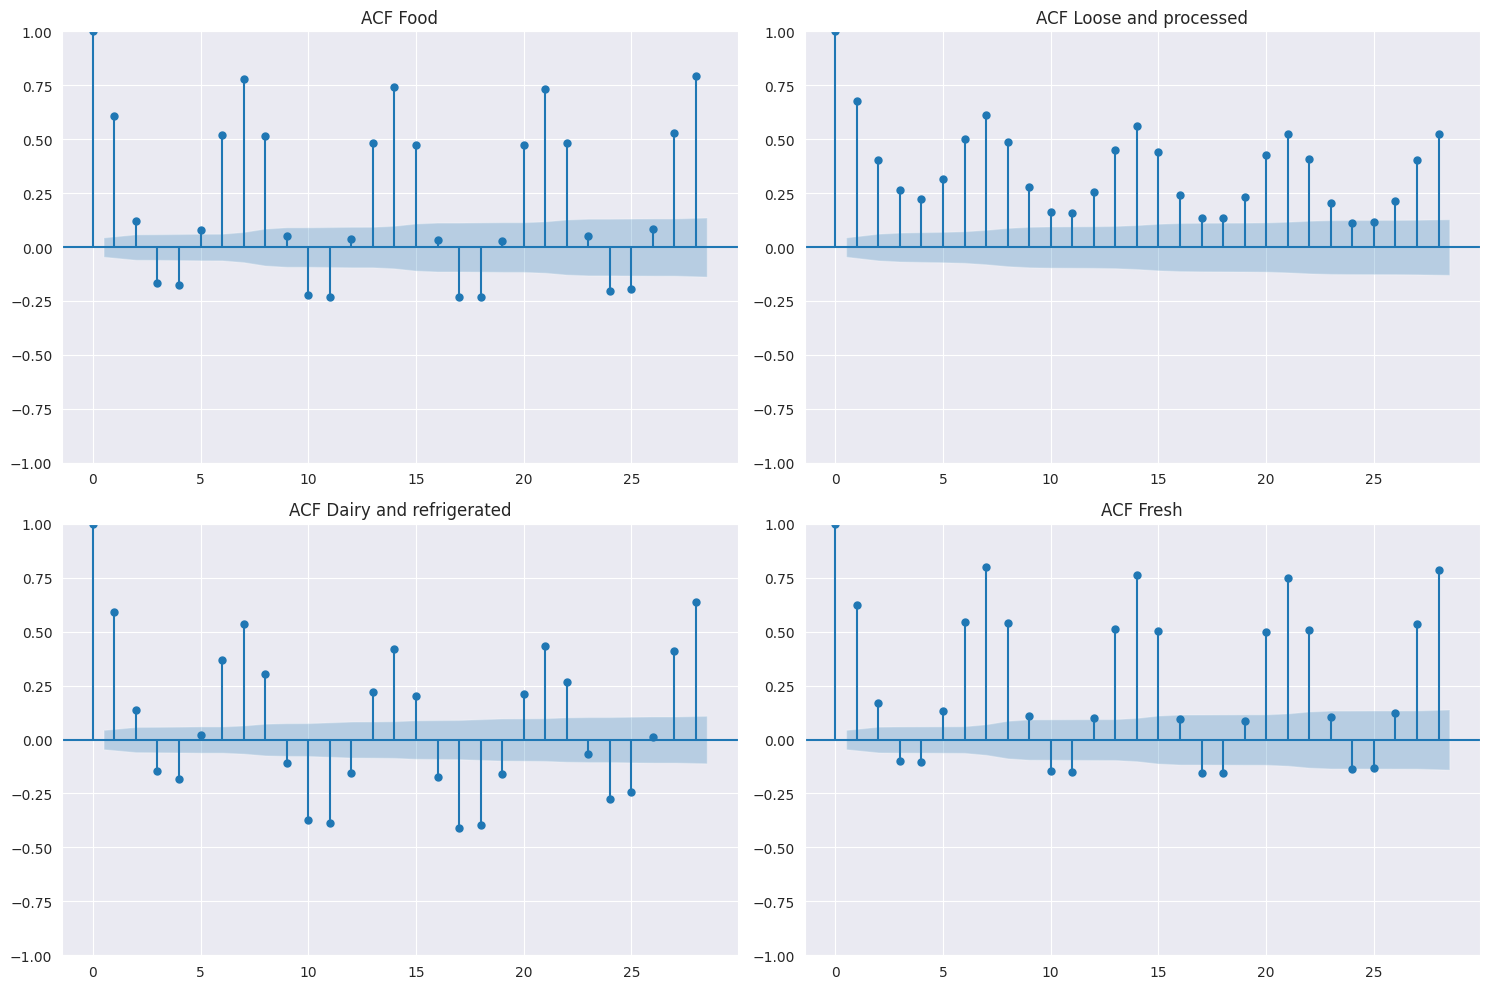

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
LAGS = 28
fig, ((foods_acf, loose_processed_acf), (dairy_refrigerated_acf, fresh_acf)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

plot_acf(foods['y'], lags=LAGS, ax=foods_acf)
foods_acf.set_title('ACF Food')

plot_acf(loose_processed['y'], lags=LAGS, ax=loose_processed_acf)
loose_processed_acf.set_title('ACF Loose and processed')

plot_acf(dairy_refrigerated['y'], lags=LAGS, ax=dairy_refrigerated_acf)
dairy_refrigerated_acf.set_title('ACF Dairy and refrigerated')

plot_acf(fresh['y'], lags=LAGS, ax=fresh_acf)
fresh_acf.set_title('ACF Fresh')

plt.tight_layout()
plt.show()

Evident weekly seasonality in each case. Interesting that loose and processed products have only positive correlation.

### Stationarity

In [29]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Tests
foods_adf = adfuller(foods['y'])
loose_processed_adf = adfuller(loose_processed['y'])
dairy_refrigerated_adf = adfuller(dairy_refrigerated['y'])
fresh_adf = adfuller(fresh['y'])

# KPSS Tests
foods_kpss = kpss(foods['y'], regression='ct')
loose_processed_kpss = kpss(loose_processed['y'], regression='ct')
dairy_refrigerated_kpss = kpss(dairy_refrigerated['y'], regression='ct')
fresh_kpss = kpss(fresh['y'], regression='ct')

print(f"KPSS p-value: {foods_kpss[1]:.4f} ADF p-value: {foods_adf[1]:.4f} - Foods")
print(f"KPSS p-value: {loose_processed_kpss[1]:.4f} ADF p-value: {loose_processed_adf[1]:.4f} - Loose and Processed")
print(f"KPSS p-value: {dairy_refrigerated_kpss[1]:.4f} ADF p-value: {dairy_refrigerated_kpss[1]:.4f} - Dairy and Processed")
print(f"KPSS p-value: {fresh_kpss[1]:.4f} ADF p-value: {fresh_kpss[1]:.4f} - Fresh")


KPSS p-value: 0.0100 ADF p-value: 0.1435 - Foods
KPSS p-value: 0.0100 ADF p-value: 0.0043 - Loose and Processed
KPSS p-value: 0.0100 ADF p-value: 0.0100 - Dairy and Processed
KPSS p-value: 0.0100 ADF p-value: 0.0100 - Fresh


/tmp/ipykernel_10970/4226047254.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  foods_kpss = kpss(foods['y'], regression='ct')
/tmp/ipykernel_10970/4226047254.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  loose_processed_kpss = kpss(loose_processed['y'], regression='ct')
/tmp/ipykernel_10970/4226047254.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  dairy_refrigerated_kpss = kpss(dairy_refrigerated['y'], regression='ct')
/tmp/ipykernel_10970/4226047254.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-

Food is only completely non-stationary time series. Strong trend.
Rest time series:
* KPPS (H1) - non-stationary around trend
* ADF (H1) - considers the data stable 

### Decomposition

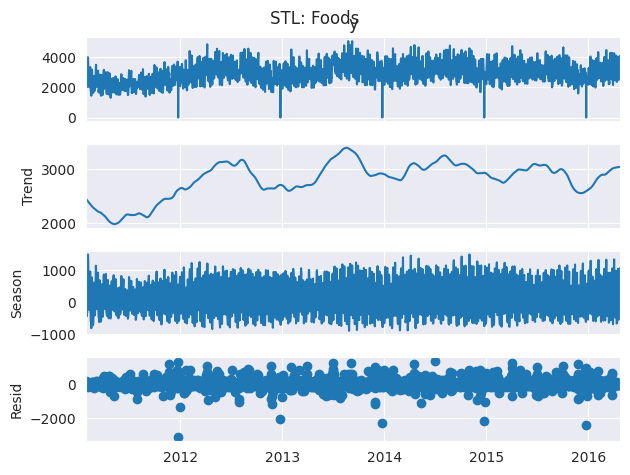

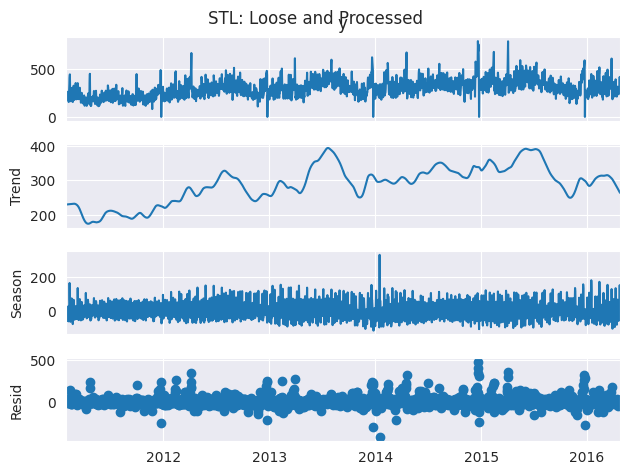

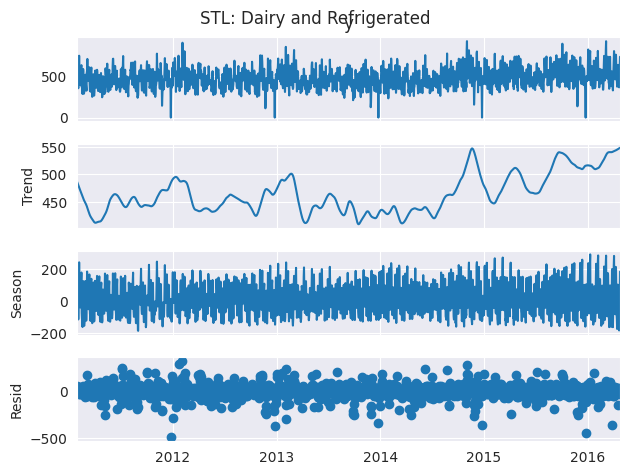

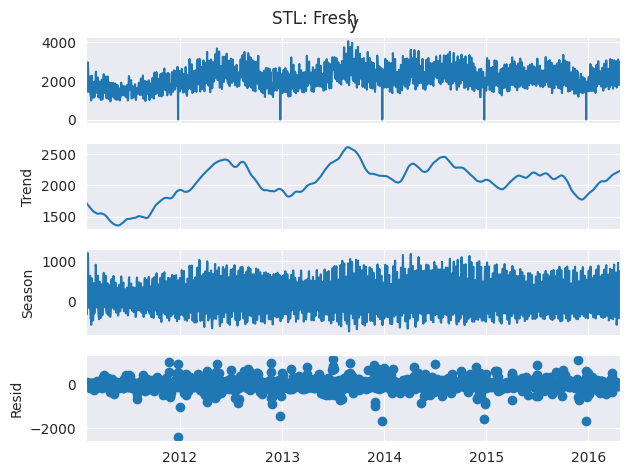

In [30]:
from statsmodels.tsa.seasonal import STL

# Foods
d_foods = foods.copy()
d_foods['ds'] = pd.to_datetime(d_foods['ds'])
d_foods = d_foods.set_index("ds")
foods_stl = STL(d_foods['y'], period=28, robust=True).fit()
foods_stl.plot()
plt.suptitle('STL: Foods')

# Loose and Processed
d_loose = loose_processed.copy()
d_loose['ds'] = pd.to_datetime(d_loose['ds'])
d_loose = d_loose.set_index("ds")
loose_stl = STL(d_loose['y'], period=28, robust=True).fit()
loose_stl.plot()
plt.suptitle('STL: Loose and Processed')

# Dairy and Refrigerated
d_dairy = dairy_refrigerated.copy()
d_dairy['ds'] = pd.to_datetime(d_dairy['ds'])
d_dairy = d_dairy.set_index("ds")
dairy_stl = STL(d_dairy['y'], period=28, robust=True).fit()
dairy_stl.plot()
plt.suptitle('STL: Dairy and Refrigerated')

# Fresh
d_fresh = fresh.copy()
d_fresh['ds'] = pd.to_datetime(d_fresh['ds'])
d_fresh = d_fresh.set_index("ds")
fresh_stl = STL(d_fresh['y'], period=28, robust=True).fit()
fresh_stl.plot()
plt.suptitle('STL: Fresh')

plt.show()


##### Normal distribution of residuals and kurtosis

In [31]:
from scipy.stats import jarque_bera, kurtosis

foods_jb = jarque_bera(foods_stl.resid)
print(f"p-value: {foods_jb.pvalue:.4f} - Foods (Jarque-Bera)")
foods_kurtosis = kurtosis(foods_stl.resid, fisher=True)
print(f"Excess Kurtosis: {foods_kurtosis:.4f} - Foods")

print("=" * 50)

loose_jb = jarque_bera(loose_stl.resid)
print(f"p-value: {loose_jb.pvalue:.4f} - Loose and Processed (Jarque-Bera)")
loose_kurtosis = kurtosis(loose_stl.resid, fisher=True)
print(f"Excess Kurtosis: {loose_kurtosis:.4f} - Loose and Processed")

print("=" * 50)

dairy_jb = jarque_bera(dairy_stl.resid)
print(f"p-value: {dairy_jb.pvalue:.4f} - Dairy and Refrigerated (Jarque-Bera)")
dairy_kurtosis = kurtosis(dairy_stl.resid, fisher=True)
print(f"Excess Kurtosis: {dairy_kurtosis:.4f} - Dairy and Refrigerated")

print("=" * 50)

fresh_jb = jarque_bera(fresh_stl.resid)
print(f"p-value: {fresh_jb.pvalue:.4f} - Fresh (Jarque-Bera)")
fresh_kurtosis = kurtosis(fresh_stl.resid, fisher=True)
print(f"Excess Kurtosis: {fresh_kurtosis:.4f} - Fresh")

p-value: 0.0000 - Foods (Jarque-Bera)
Excess Kurtosis: 19.5377 - Foods
p-value: 0.0000 - Loose and Processed (Jarque-Bera)
Excess Kurtosis: 13.6975 - Loose and Processed
p-value: 0.0000 - Dairy and Refrigerated (Jarque-Bera)
Excess Kurtosis: 8.8749 - Dairy and Refrigerated
p-value: 0.0000 - Fresh (Jarque-Bera)
Excess Kurtosis: 16.3879 - Fresh


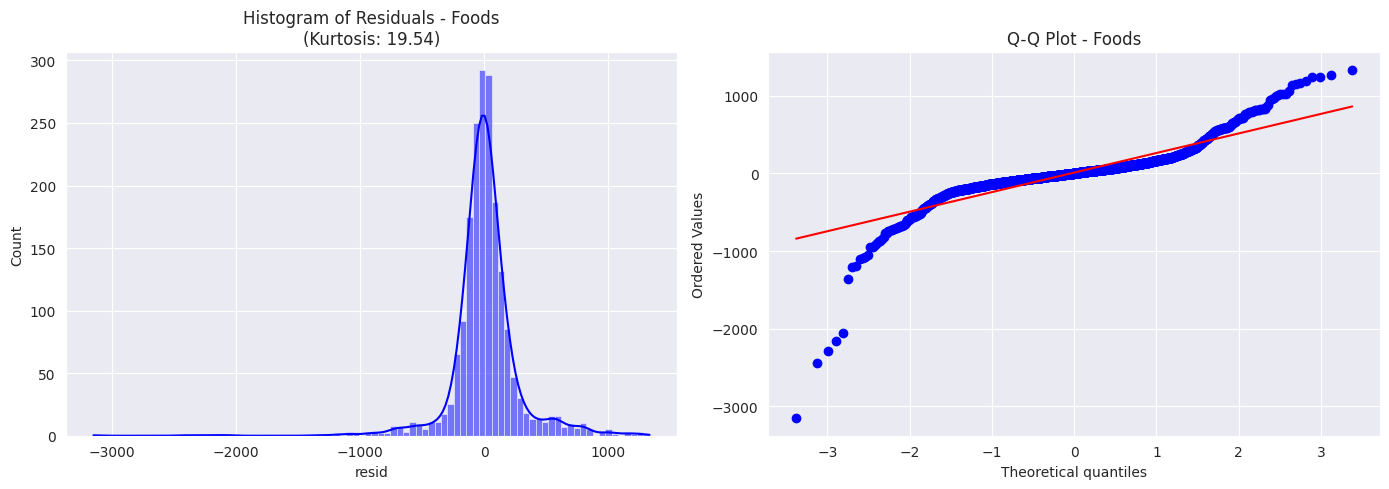

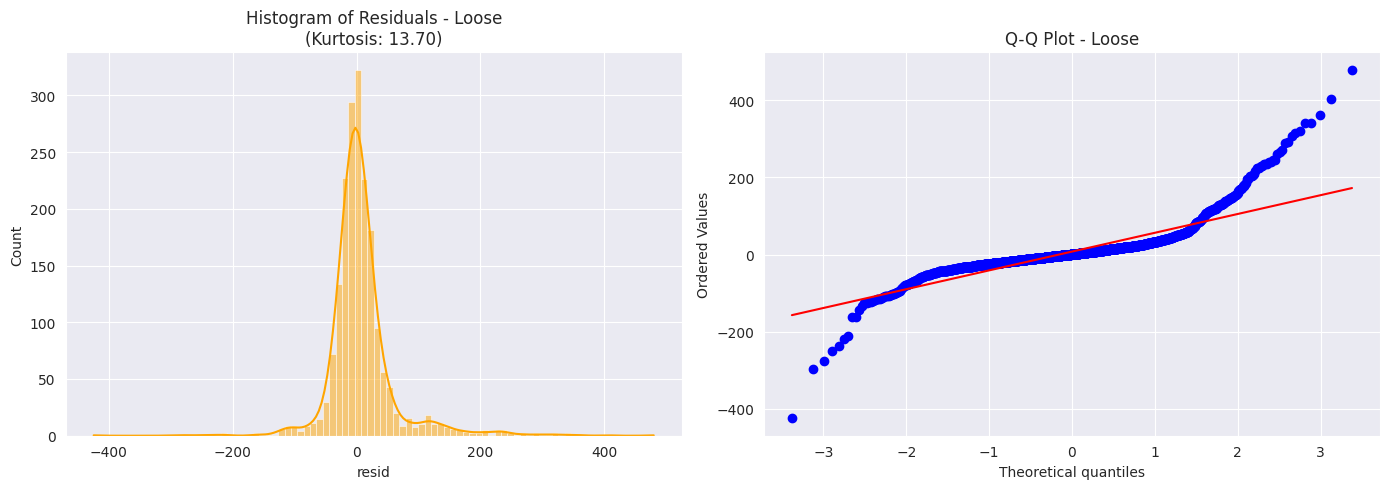

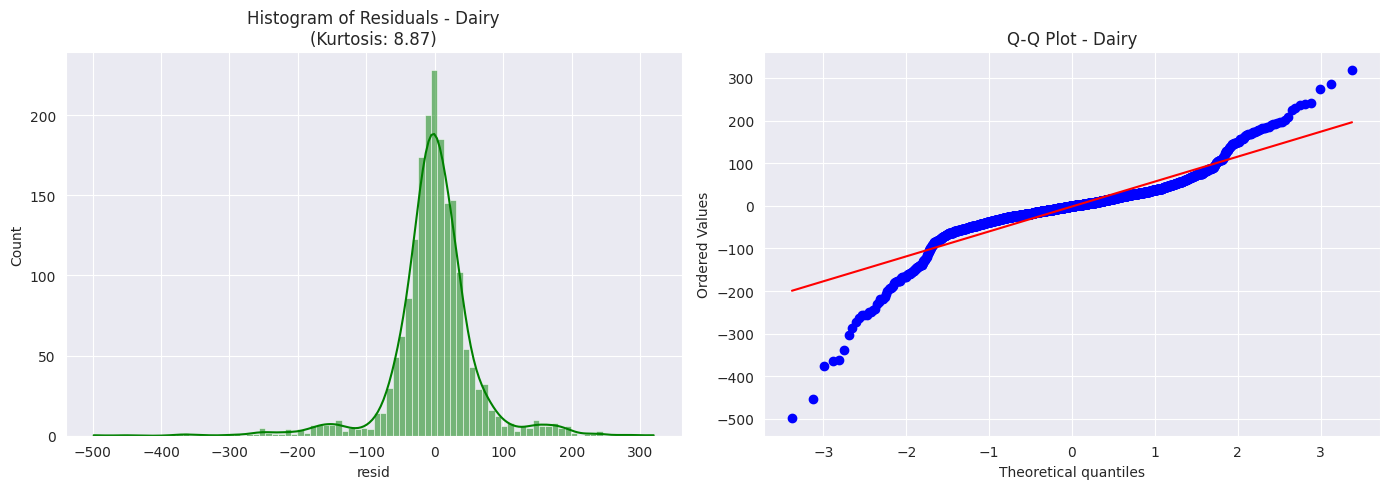

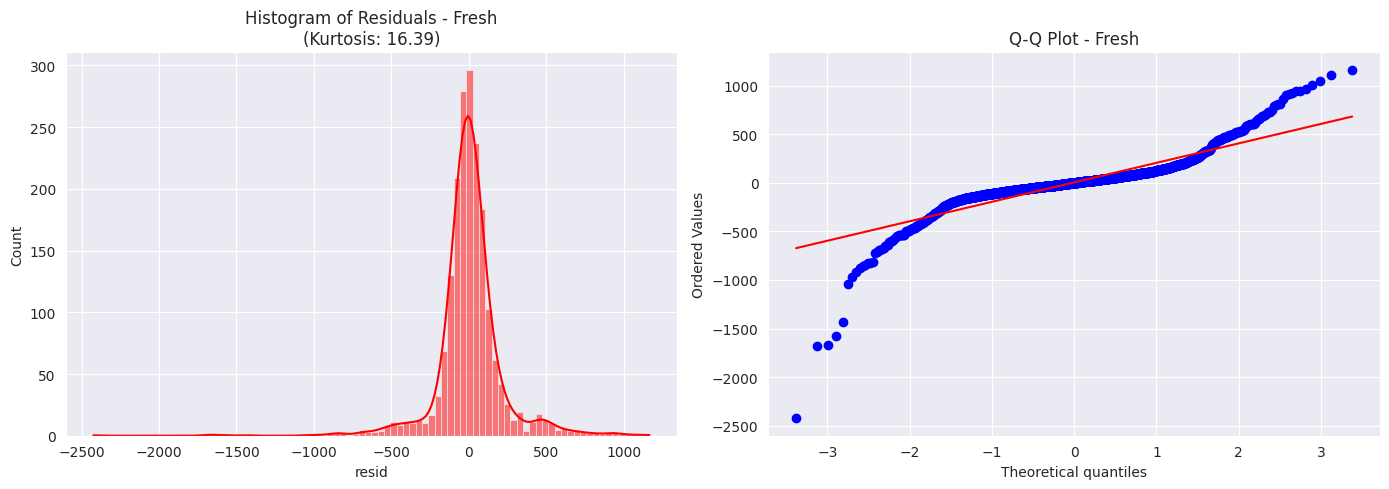

In [32]:
import scipy.stats as stats
import seaborn as sns

# Foods
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(foods_stl.resid, kde=True, ax=ax1, color='blue')
ax1.set_title(f"Histogram of Residuals - Foods\n(Kurtosis: {foods_kurtosis:.2f})")
stats.probplot(foods_stl.resid, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot - Foods")
plt.tight_layout()
plt.show()

# Loose and Processed
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(loose_stl.resid, kde=True, ax=ax1, color='orange')
ax1.set_title(f"Histogram of Residuals - Loose\n(Kurtosis: {loose_kurtosis:.2f})")
stats.probplot(loose_stl.resid, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot - Loose")
plt.tight_layout()
plt.show()

# Dairy and Refrigerated
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(dairy_stl.resid, kde=True, ax=ax1, color='green')
ax1.set_title(f"Histogram of Residuals - Dairy\n(Kurtosis: {dairy_kurtosis:.2f})")
stats.probplot(dairy_stl.resid, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot - Dairy")
plt.tight_layout()
plt.show()

# Fresh
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(fresh_stl.resid, kde=True, ax=ax1, color='red')
ax1.set_title(f"Histogram of Residuals - Fresh\n(Kurtosis: {fresh_kurtosis:.2f})")
stats.probplot(fresh_stl.resid, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot - Fresh")
plt.tight_layout()
plt.show()

None of the time series have residuals from normal distribution. All of residuals are leptokurtic. Big errors on days with high sales and days with the lowest sales

## Exponential Smoothing

In [33]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Foods
d_foods['y'] = d_foods['y'].replace(0, 1)
foods_exp = ExponentialSmoothing(d_foods["y"], trend="add", seasonal="add", seasonal_periods=7, freq='D')
foods_fit = foods_exp.fit()
foods_exp_forecast = foods_fit.forecast(28)

# Loose and Processed
d_loose = loose_processed.copy()
d_loose['ds'] = pd.to_datetime(d_loose['ds'])
d_loose = d_loose.set_index("ds")
d_loose = d_loose.asfreq('D')
d_loose['y'] = d_loose['y'].replace(0, 1)

loose_exp = ExponentialSmoothing(d_loose["y"], trend="add", seasonal="add", seasonal_periods=7, freq='D')
loose_fit = loose_exp.fit()
loose_exp_forecast = loose_fit.forecast(28)

# Dairy and Refrigerated
d_dairy = dairy_refrigerated.copy()
d_dairy['ds'] = pd.to_datetime(d_dairy['ds'])
d_dairy = d_dairy.set_index("ds")
d_dairy = d_dairy.asfreq('D')
d_dairy['y'] = d_dairy['y'].replace(0, 1)

dairy_exp = ExponentialSmoothing(d_dairy["y"], trend="add", seasonal="add", seasonal_periods=7, freq='D')
dairy_fit = dairy_exp.fit()
dairy_exp_forecast = dairy_fit.forecast(28)

# Fresh
d_fresh = fresh.copy()
d_fresh['ds'] = pd.to_datetime(d_fresh['ds'])
d_fresh = d_fresh.set_index("ds")
d_fresh = d_fresh.asfreq('D')
d_fresh['y'] = d_fresh['y'].replace(0, 1)

fresh_exp = ExponentialSmoothing(d_fresh["y"], trend="add", seasonal="add", seasonal_periods=7, freq='D')
fresh_fit = fresh_exp.fit()
fresh_exp_forecast = fresh_fit.forecast(28)

## Prophet

In [34]:
from prophet import Prophet
from sklearn.model_selection import ParameterGrid
from prophet.diagnostics import cross_validation, performance_metrics

# Creating holidays dataframe
h1 = foods[foods["event_name_1"] != "None"][["event_name_1", "ds"]].rename(columns={"event_name_1": "holiday"})
h2 = foods[foods["event_name_2"] != "None"][["event_name_2", "ds"]].rename(columns={"event_name_2": "holiday"})
snap = foods[foods["snap_CA"] != 0][["snap_CA", "ds"]].rename(columns={"snap_CA": "holiday"})
snap["holiday"] = snap["holiday"].astype("str")

holidays = pd.concat([h1, h2, snap])

# Dataframes for Prophet
foods_prophet_df = foods[["ds","y"]]
loose_processed_prophet_df =  loose_processed[["ds","y"]]
dairy_refrigerated_prophet_df = dairy_refrigerated[["ds","y"]]
fresh_prophet_df = fresh[["ds","y"]]

# Param Grid
param_grid = {
    'changepoint_prior_scale': [0.05, 0.1, 0.3],
    'holidays_prior_scale': [1.0, 10.0],
    'seasonality_prior_scale': [1.0, 10.0]
}


def prophet_compute(df, param_grid, holidays):
    """
    Computes prophet model with the best hyperparameters

    :param df: DataFrame with columns: ds and y
    :param param_grid: dictionary with parameters
    :param holidays: DataFrame with columns: holiday, ds
    :return: Prophet
    """

    grid = ParameterGrid(param_grid)
    results = []

    # Grid Search
    for p in grid:
        m = Prophet(
            holidays=holidays,
            changepoint_prior_scale=p['changepoint_prior_scale'],
            holidays_prior_scale=p['holidays_prior_scale'],
            seasonality_prior_scale=p['seasonality_prior_scale'],
            weekly_seasonality=True, # ACF, peaks every 7 days
            yearly_seasonality=True,
            seasonality_mode='additive' # Decomposition, seasonality variance don't fluctuate with trend
        )
        m.fit(df)

        # Cross-Validation
        df_cv = cross_validation(m, initial='730 days', period='90 days', horizon='28 days', parallel="processes")
        df_p = performance_metrics(df_cv)

        res = p.copy()
        res['mae'] = df_p['mae'].mean()
        res['rmse'] = df_p['rmse'].mean()
        results.append(res)

    results_df = pd.DataFrame(results).sort_values('mae')

    # Best parameters
    best_p = pd.DataFrame(results).sort_values('mae').iloc[0]

    # Train final model
    final_model = Prophet(
        holidays=holidays,
        changepoint_prior_scale=best_p['changepoint_prior_scale'],
        holidays_prior_scale=best_p['holidays_prior_scale'],
        seasonality_prior_scale=best_p['seasonality_prior_scale'],
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='additive'
    )
    return final_model.fit(df), results_df

# Training models for each datasett
foods_prophet, food_results = prophet_compute(foods_prophet_df, param_grid, holidays)
loose_processed_prophet, loose_processed_results = prophet_compute(loose_processed_prophet_df, param_grid, holidays)
dairy_refrigerated_prophet, dairy_refrigerated_results = prophet_compute(dairy_refrigerated_prophet_df, param_grid, holidays)
fresh_prophet, fresh_results = prophet_compute(fresh_prophet_df, param_grid, holidays)

10:39:40 - cmdstanpy - INFO - Chain [1] start processing
10:39:41 - cmdstanpy - INFO - Chain [1] done processing
10:39:41 - cmdstanpy - INFO - Chain [1] start processing
10:39:41 - cmdstanpy - INFO - Chain [1] start processing
10:39:41 - cmdstanpy - INFO - Chain [1] start processing
10:39:41 - cmdstanpy - INFO - Chain [1] start processing
10:39:41 - cmdstanpy - INFO - Chain [1] start processing
10:39:41 - cmdstanpy - INFO - Chain [1] start processing
10:39:41 - cmdstanpy - INFO - Chain [1] start processing
10:39:41 - cmdstanpy - INFO - Chain [1] start processing
10:39:41 - cmdstanpy - INFO - Chain [1] start processing
10:39:41 - cmdstanpy - INFO - Chain [1] start processing
10:39:41 - cmdstanpy - INFO - Chain [1] done processing
10:39:41 - cmdstanpy - INFO - Chain [1] start processing
10:39:41 - cmdstanpy - INFO - Chain [1] done processing
10:39:41 - cmdstanpy - INFO - Chain [1] start processing
10:39:41 - cmdstanpy - INFO - Chain [1] done processing
10:39:41 - cmdstanpy - INFO - Chain

### Forecasts

In [35]:
def predict_forecast(model, periods=28):
    """
    Predictions from Prophet model

    :param model: Prophet fitted model
    :param periods: Days to predict
    :return: DataFrame with forecasts
    """

    future = model.make_future_dataframe(periods=periods, freq='D')
    forecast = model.predict(future)

    return forecast

foods_forecast = predict_forecast(foods_prophet)
loose_forecast = predict_forecast(loose_processed_prophet)
dairy_forecast = predict_forecast(dairy_refrigerated_prophet)
fresh_forecast = predict_forecast(fresh_prophet)

## Test

##### Test set

In [36]:
ca1_evaluation = evaluation[evaluation["store_id"] == "CA_1"]

ca1_evaluation_columns_d = []
for col in ca1_evaluation.columns:
    if col.startswith("d_") and int(col.split('_')[1]) > 1913:
        ca1_evaluation_columns_d.append(col)

ca1_evaluation_long = pd.melt(ca1_evaluation,
                              value_vars=ca1_evaluation_columns_d,
                              id_vars=["item_id", "dept_id", "cat_id"],
                              var_name="d_id", value_name="quantity_sold")

ca1_evaluation_calendar = pd.merge(ca1_evaluation_long, calendar[["d", "date"]],
                                   how="inner", left_on="d_id", right_on="d")

ca1_evaluation_calendar["date"] = pd.to_datetime(ca1_evaluation_calendar["date"])
ca1_evaluation_calendar.rename(columns={"date": "ds", "quantity_sold": "y"}, inplace=True)

# Foods
foods_eval = ca1_evaluation_calendar[ca1_evaluation_calendar["cat_id"] == "FOODS"].groupby("ds")["y"].sum().reset_index()

# Loose and processed
loose_eval = ca1_evaluation_calendar[ca1_evaluation_calendar["dept_id"] == "FOODS_1"].groupby("ds")["y"].sum().reset_index()

# Dairy and Refrigerated
dairy_eval = ca1_evaluation_calendar[ca1_evaluation_calendar["dept_id"] == "FOODS_2"].groupby("ds")["y"].sum().reset_index()

# Fresh
fresh_eval = ca1_evaluation_calendar[ca1_evaluation_calendar["dept_id"] == "FOODS_3"].groupby("ds")["y"].sum().reset_index()

### Comparision

#### Foods

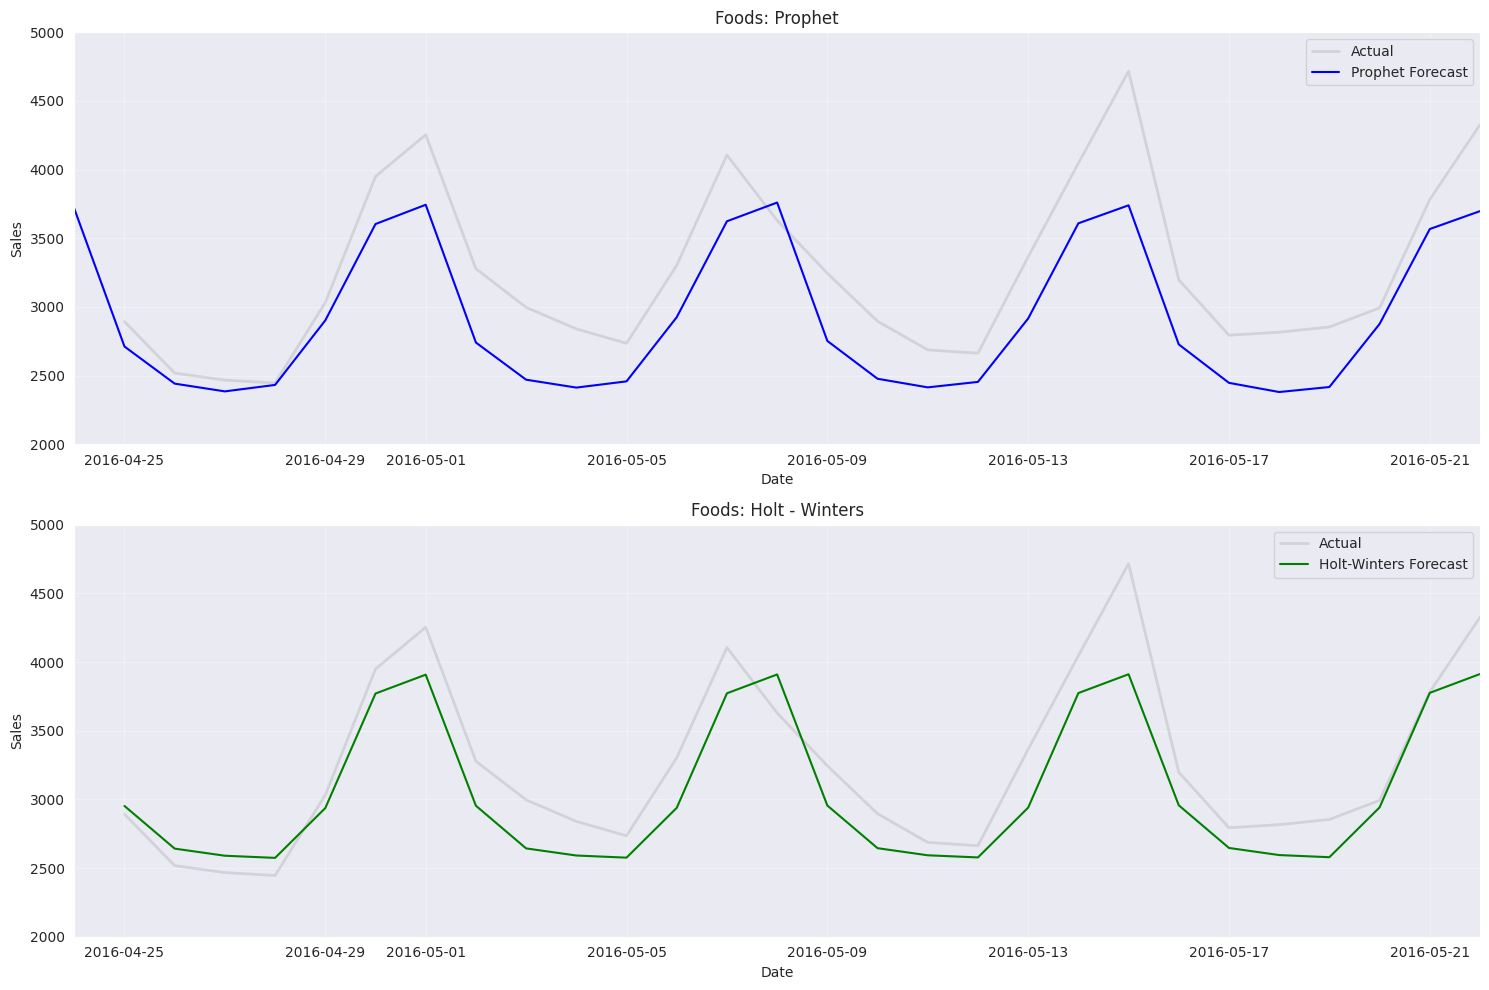

In [37]:
last_date = foods_forecast['ds'].max()
start_date = last_date - pd.Timedelta(days=28)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Prophet
ax1.set_title("Foods: Prophet")
ax1.plot(foods_eval['ds'], foods_eval['y'], label='Actual', color='black', linewidth=2, alpha=0.1)
# ax1.plot(foods_prophet_df['ds'], foods_prophet_df['y'], label='Actual (Train)' )
ax1.plot(foods_forecast['ds'], foods_forecast['yhat'], label='Prophet Forecast', color='blue')
ax1.set_xlim([start_date, last_date])
ax1.set_ylim([2000, 5000])
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")

# Exponential Smoothing Holt Winters
ax2.set_title("Foods: Holt - Winters")
ax2.plot(foods_eval['ds'], foods_eval['y'], label='Actual', color='black', linewidth=2, alpha=0.1)
# ax2.plot(foods_prophet_df['ds'], foods_prophet_df['y'], label='Actual (Train)' )
ax2.plot(foods_eval['ds'], foods_exp_forecast, label='Holt-Winters Forecast', color='green')
ax2.set_xlim([start_date, last_date])
ax2.set_ylim([2000, 5000])
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales")

plt.tight_layout()
plt.show()

#### Loose and Processed

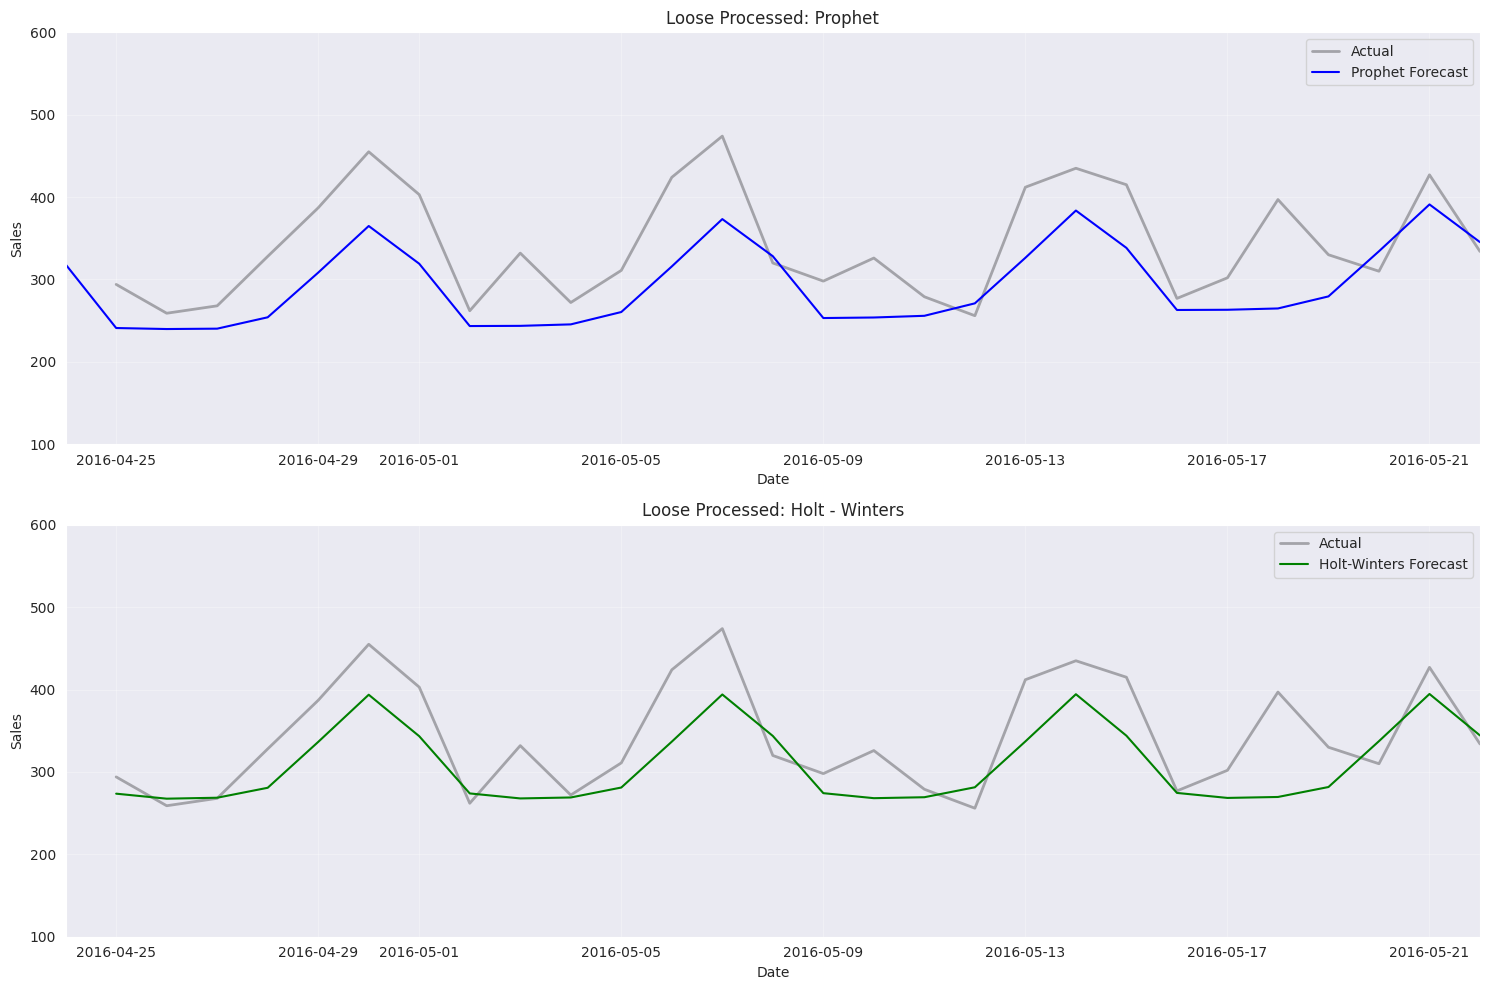

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Prophet
ax1.set_title("Loose Processed: Prophet")
ax1.plot(loose_eval['ds'], loose_eval['y'], label='Actual', color='black', linewidth=2, alpha=0.3)
ax1.plot(loose_forecast['ds'], loose_forecast['yhat'], label='Prophet Forecast', color='blue')
ax1.set_xlim([start_date, last_date])
ax1.set_ylim([100, 600])
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")

# Holt-Winters
ax2.set_title("Loose Processed: Holt - Winters")
ax2.plot(loose_eval['ds'], loose_eval['y'], label='Actual', color='black', linewidth=2, alpha=0.3)
ax2.plot(loose_eval['ds'], loose_exp_forecast, label='Holt-Winters Forecast', color='green')
ax2.set_xlim([start_date, last_date])
ax2.set_ylim([100, 600])
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales")

plt.tight_layout()
plt.show()

#### Dairy and Refrigerated

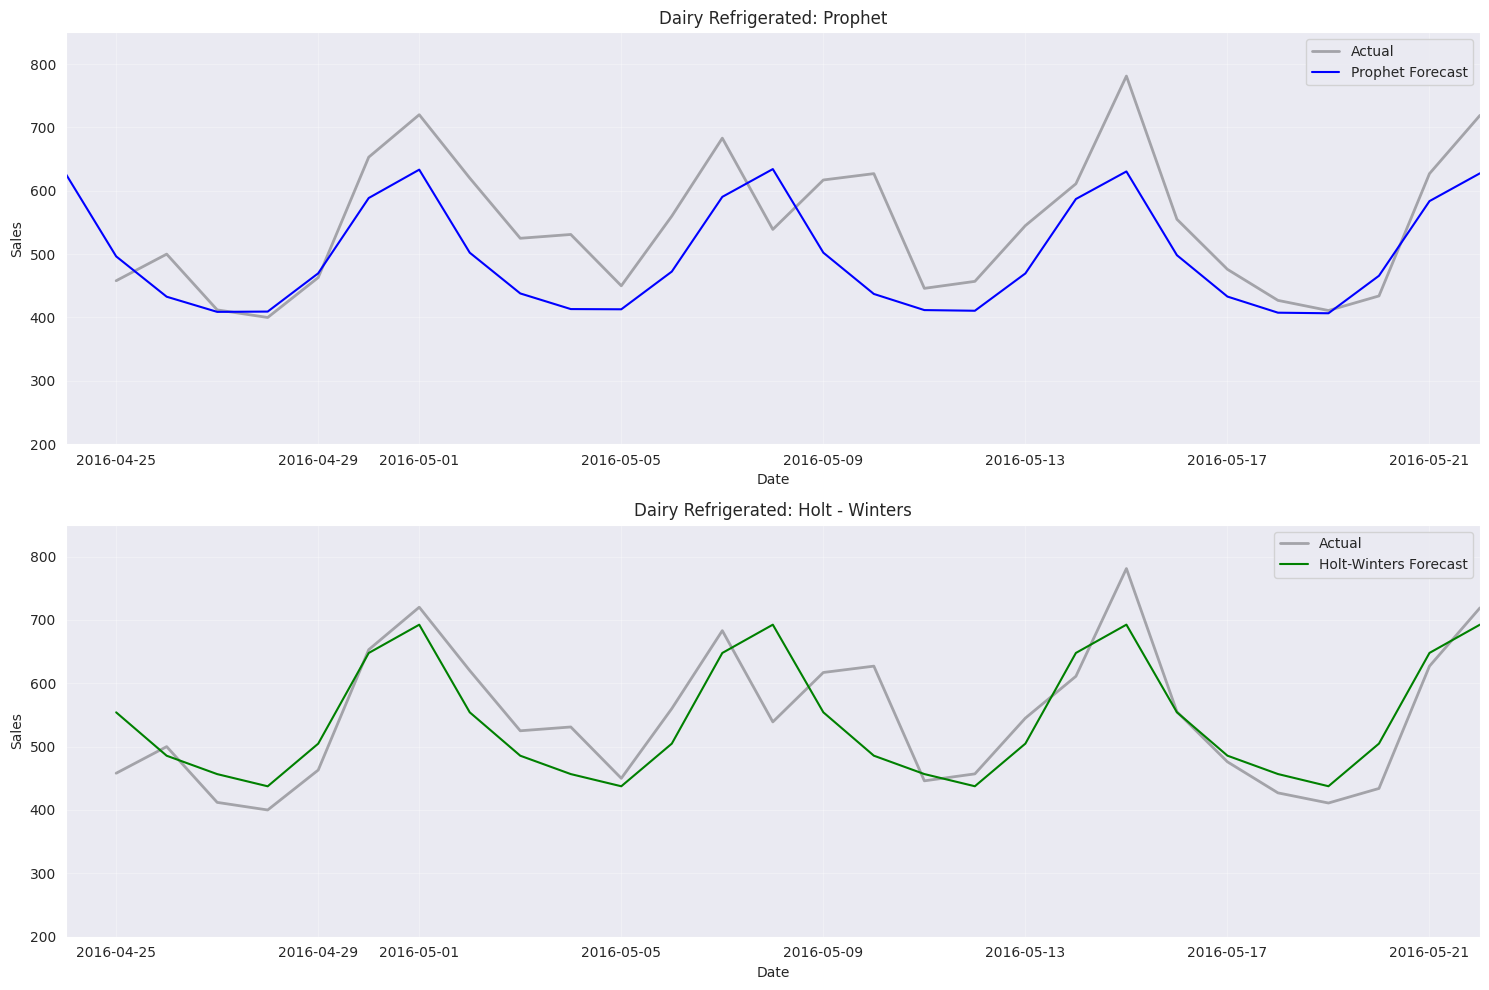

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Prophet
ax1.set_title("Dairy Refrigerated: Prophet")
ax1.plot(dairy_eval['ds'], dairy_eval['y'], label='Actual', color='black', linewidth=2, alpha=0.3)
ax1.plot(dairy_forecast['ds'], dairy_forecast['yhat'], label='Prophet Forecast', color='blue')
ax1.set_xlim([start_date, last_date])
ax1.set_ylim([200, 850])
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")

# Holt-Winters
ax2.set_title("Dairy Refrigerated: Holt - Winters")
ax2.plot(dairy_eval['ds'], dairy_eval['y'], label='Actual', color='black', linewidth=2, alpha=0.3)
ax2.plot(dairy_eval['ds'], dairy_exp_forecast, label='Holt-Winters Forecast', color='green')
ax2.set_xlim([start_date, last_date])
ax2.set_ylim([200, 850])
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales")

plt.tight_layout()
plt.show()

#### Fresh

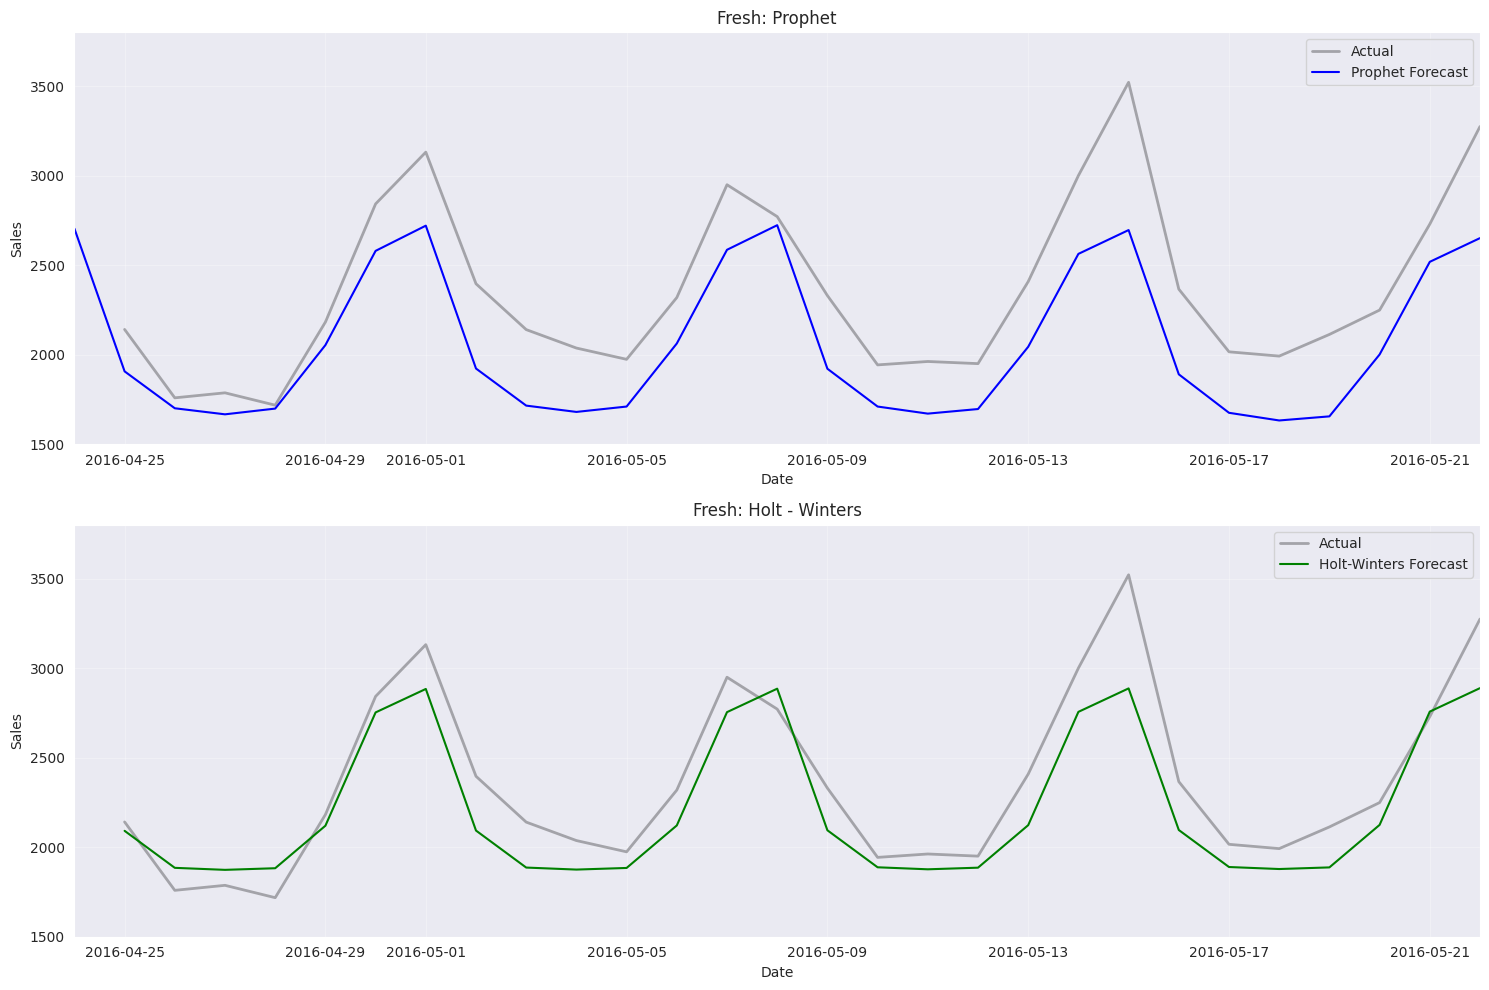

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Prophet
ax1.set_title("Fresh: Prophet")
ax1.plot(fresh_eval['ds'], fresh_eval['y'], label='Actual', color='black', linewidth=2, alpha=0.3)
ax1.plot(fresh_forecast['ds'], fresh_forecast['yhat'], label='Prophet Forecast', color='blue')
ax1.set_xlim([start_date, last_date])
ax1.set_ylim([1500, 3800])
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")

# Holt-Winters
ax2.set_title("Fresh: Holt - Winters")
ax2.plot(fresh_eval['ds'], fresh_eval['y'], label='Actual', color='black', linewidth=2, alpha=0.3)
ax2.plot(fresh_eval['ds'], fresh_exp_forecast, label='Holt-Winters Forecast', color='green')
ax2.set_xlim([start_date, last_date])
ax2.set_ylim([1500, 3800])
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales")

plt.tight_layout()
plt.show()

#### Metrics

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

datasets_to_compare = [
    ("Foods", foods_eval, foods_forecast, foods_exp_forecast),
    ("Loose Processed", loose_eval, loose_forecast, loose_exp_forecast),
    ("Dairy Refrigerated", dairy_eval, dairy_forecast, dairy_exp_forecast),
    ("Fresh", fresh_eval, fresh_forecast, fresh_exp_forecast)
]

results = []

for name, df_eval, df_prophet, pred_hw in datasets_to_compare:
    y_true = df_eval['y']

    y_pred_prophet = df_prophet.tail(len(y_true))['yhat']
    y_pred_hw = pred_hw

    mae_p = mean_absolute_error(y_true, y_pred_prophet)
    mae_hw = mean_absolute_error(y_true, y_pred_hw)

    mape_p = mean_absolute_percentage_error(y_true, y_pred_prophet)
    mape_hw = mean_absolute_percentage_error(y_true, y_pred_hw)

    rmse_p = np.sqrt(mean_squared_error(y_true, y_pred_prophet))
    rmse_hw = np.sqrt(mean_squared_error(y_true, y_pred_hw))

    results.append({
        "Category": name,
        "Prophet MAE": mae_p,
        "HW MAE": mae_hw,
        "Prophet RMSE": rmse_p,
        "HW RMSE": rmse_hw,
        "Prophet MAPE (%)": mape_p * 100,
        "HW MAPE (%)": mape_hw * 100,
        "Best Model (MAE)": "Prophet" if mae_p < mae_hw else "Holt-Winters"
    })

metrics_df = pd.DataFrame(results)

print("Metrics")
cols_to_show = ['Category', 'Prophet MAE', 'HW MAE', 'Prophet RMSE', 'HW RMSE', 'Prophet MAPE (%)', 'HW MAPE (%)', 'Best Model (MAE)']
print(metrics_df[cols_to_show].round(2))

Metrics
             Category  Prophet MAE  HW MAE  Prophet RMSE  HW RMSE  \
0               Foods       357.53  239.04        410.79   286.19   
1     Loose Processed        53.69   40.46         63.14    50.29   
2  Dairy Refrigerated        65.59   46.00         79.73    59.11   
3               Fresh       319.47  179.32        362.38   218.63   

   Prophet MAPE (%)  HW MAPE (%) Best Model (MAE)  
0             10.67         7.09     Holt-Winters  
1             14.88        10.98     Holt-Winters  
2             11.31         8.54     Holt-Winters  
3             13.24         7.33     Holt-Winters  
